We consider solutions to the modified Fisher equation
\begin{equation}
    \frac{\partial \rho}{\partial t} = \frac{\partial}{\partial x}\left(\rho \frac{\partial \rho}{\partial x}\right) + \rho(1 − \rho).
\end{equation}
corresponding to steady expansion of a saturated population. Write $\rho(x, t) = \phi(\xi)$, where $\xi = x - ct - x_0$. To transform the PDE for $\rho$ into an ODE for $\phi$, we need to express the partial derivatives of $\rho$ with respect to $t$ and $x$ in terms of the derivatives of $\phi$ with respect to $\xi$. Compute $\frac{\partial \xi}{\partial t} = -c$ and
\begin{equation}
    \frac{\partial \rho}{\partial t} = \frac{d\phi}{d\xi}\frac{\partial \xi}{\partial t} = -c\frac{d\phi}{d\xi} = -c\phi.
\end{equation}
Also, $\frac{\partial \xi}{\partial x} = 1$, so
\begin{equation}
    \frac{\partial \rho}{\partial x} = \frac{d\phi}{d\xi}\frac{\partial \xi}{\partial x} = \frac{d\phi}{d\xi}  = \phi.
\end{equation}
We apply the chain rule and product rule,
\begin{equation}
    \frac{\partial}{\partial x}(\phi \phi') = \frac{d}{d\xi}(\phi \phi ')\frac{\partial \xi}{\partial x} = \frac{d\phi}{d\xi}\phi' + \phi\frac{d\phi'}{d\xi} = (\phi')^2 + \phi\phi''.
\end{equation}
Now we can substitute all the derived expressions back into the original equation and rearrange to obtain
\begin{equation}
    \phi\phi'' + (\phi')^2 + c\phi' + \phi(1 - \phi) = 0.
\end{equation}
This is to be solved subject to the boundary conditions $\phi \to 1$ as $\xi \to -\infty$, and $\phi \to 0$ as $\xi \to \infty$. General analytic solutions to are not available and hence numerical solutions are required. Such solutions could be obtained by shooting, but here it is preferable to consider the asymptotic form of $\phi$ as $\xi \to -\infty$.

We want to linearise this equation around the point $\phi = 1$. Introduce a small perturbation $\phi = 1 - \epsilon$. We can make the following approximations,
\begin{align}
    &\phi \approx 1 \\
    &\phi' = -\epsilon' \\
    &\phi'' = -\epsilon'' \\
    &(\phi')^2 = (-\epsilon')^2 \approx 0 \\
    &\phi(1 - \phi) \approx \epsilon.
\end{align}
Now, we substitute these approximations back into the original ODE,
\begin{equation}
    -\epsilon'' + 0 + c(-\epsilon') + \epsilon = -\epsilon'' - c\epsilon' + \epsilon = 0.
\end{equation}
Or, by multiplying by -1,
\begin{equation}
    \epsilon'' + c\epsilon' - \epsilon = 0.
\end{equation}
This gives us the characteristic equation for a second order linear ODE,
\begin{equation}
    \lambda^2 + c\lambda - 1 = 0
\end{equation}
which has roots
\begin{equation}
    \lambda = \frac{-c \pm \sqrt{c^2 + 4}}{2}.
\end{equation}
As $\xi \to -\infty$, we need $\phi \to 1$ or equivalently $\epsilon \to 0$. Using properties of exponentials, we take the positive root. This yields the asymptotic form as $\xi \to -\infty$
\begin{equation}
    \phi \sim 1 - Ae^{\lambda \xi}
\end{equation}
for an arbitrary constant $A$. This then provides suitable initial conditions for a forward integration in $\xi$,
\begin{equation}
    \phi(\xi_0) = 1 − \delta, \quad \phi'(\xi_0) = −\lambda\delta, \quad \delta \ll 1,
\end{equation}
for arbitrary $\xi_0$. We need to take sufficiently negative $\xi_0$ and small $\delta$ in the numerical solver.

We first transforme our second order ODE into a system of two first-order ODEs. Define a vector $(x, y) = (\phi, \phi')$, so its derivative is $(x', y') = (\phi', \phi'')$. The system can then be written as
\begin{align}
    x' = y, \\
    y' = \frac{-y^2 - cy - x(1 - x)}{x}.
\end{align}
We normalise the origin such that $\phi(0) = 0.5$ by shifting the entire $\xi$-axis to align the wave profiles on the same graph.

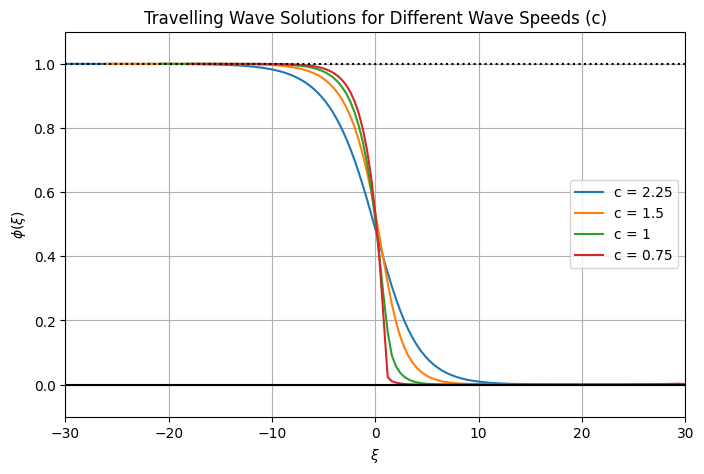

In [110]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def get_lambda(c):
    '''
    Calculates the positive root lambda based on the wave speed c.
    '''
    return (-c + np.sqrt(c**2 + 4)) / 2

def ode_system(xi, y, c):
    '''
    Defines the system of first-order ODEs.
    '''
    phi, phi_prime = y
    if phi == 0:
        return [phi_prime, 0]

    phi_double_prime = (-phi_prime**2 - c * phi_prime - phi * (1 - phi)) / phi
    return [phi_prime, phi_double_prime]

def solve_wave_equation(c):
    '''
    Solves the ODE for a given c and returns the numerical solution.
    '''
    xi_span = [-100, 100]   # A wide range to ensure the full wave is captured
    delta = 1e-6            # A small perturbation for the initial condition

    # Calculate lambda and set initial conditions deep in the asymptotic region
    lam = get_lambda(c)
    y0 = [1.0 - delta, -lam * delta]

    # Solve the ODE using a solver suitable for stiff problems
    solution = solve_ivp(
        fun=ode_system,
        t_span=xi_span,
        y0=y0,
        args=(c,),
        dense_output=True,
        method='LSODA'
    )
    return solution

def normalise_and_get_profile(solution):
    '''
    Normalises the solution so phi(0) = 0.5 and returns plottable arrays.
    '''
    # Create a smooth curve from the solver's dense output
    xi_dense = np.linspace(solution.t[0], solution.t[-1], 500)
    phi_dense = solution.sol(xi_dense)[0]

    # Find the value of xi where phi is closest to 0.5
    origin_shift_index = np.argmin(np.abs(phi_dense - 0.5))
    origin_shift_value = xi_dense[origin_shift_index]

    # Shift the xi axis to set the origin at that point
    xi_shifted = xi_dense - origin_shift_value

    return xi_shifted, phi_dense

def plot_solutions(c_values):
    '''
    Solving and plotting function.
    '''
    plt.figure(figsize=(8, 5))

    for c in c_values:
        sol = solve_wave_equation(c)
        xi, phi = normalise_and_get_profile(sol)
        plt.plot(xi, phi, label=f'c = {c}')

    plt.title('Travelling Wave Solutions for Different Wave Speeds (c)')
    plt.xlabel(f'$\\xi$')
    plt.ylabel(f'$\\phi(\\xi)$')
    plt.grid(True)
    plt.legend()
    plt.xlim(-30, 30)
    plt.ylim(-0.1, 1.1)
    plt.axhline(0, color='black')
    plt.axhline(1, color='black', linestyle=':')
    plt.show()

c_main = [2.25, 1.5, 1, 0.75]
plot_solutions(c_main)

We can claim for some value of $c$ that for $\xi < \xi_1$, a solution can be given by
\begin{equation}
\phi(\xi) = 1 - e^{(\xi - \xi_1)/\sqrt{2}}
\end{equation}
First, we find the first and second derivatives of with respect to $\xi$,
\begin{align}
    \phi'(\xi) &= - \frac{1}{\sqrt{2}} e^{(\xi - \xi_1)/\sqrt{2}}, \\
    \phi''(\xi) &= - \frac{1}{2} e^{(\xi - \xi_1)/\sqrt{2}}.
\end{align}
Now, we substitute each expression into the ODE. To simplify the substitution, notice that we can express the exponential term as $e^{(\xi - \xi_1)/\sqrt{2}} = 1 - \phi$,
Now, substitute these simplified derivatives into the ODE:
\begin{equation}
    \frac{\phi(1 - \phi)}{2} + \frac{(1 - \phi)^2}{2} - \frac{c(1 - \phi)}{\sqrt{2}} = 0.
\end{equation}
We can factor out the common term to obtain
\begin{equation}
    \frac{1 - \phi}{2}(1 - c\sqrt 2) = 0.
\end{equation}
This equation must hold true for all $\phi \in (0, 1)$, which is only possible if $c = 1/\sqrt{2}$. For the region $\xi_1 \leq \xi$, we define $\phi(\xi) = 0$. To normalise the origin, we choose $\xi_1$ such that $\phi(0) = 1/2$. This solves to $\xi_1 = \sqrt{2}\log{2}$.

Unlike the smooth, continuously differentiable solutions obtained numerically for other values of $c$, this solution has a corner. At $\xi = \xi_1$, the function $\phi$ is continuous but its derivative $\phi'$ is not. This represents an abrupt stop to the population gradient. The shape of the wave front is a simple exponential decay towards the saturated state $\phi=1$ as $\xi \to -\infty$.

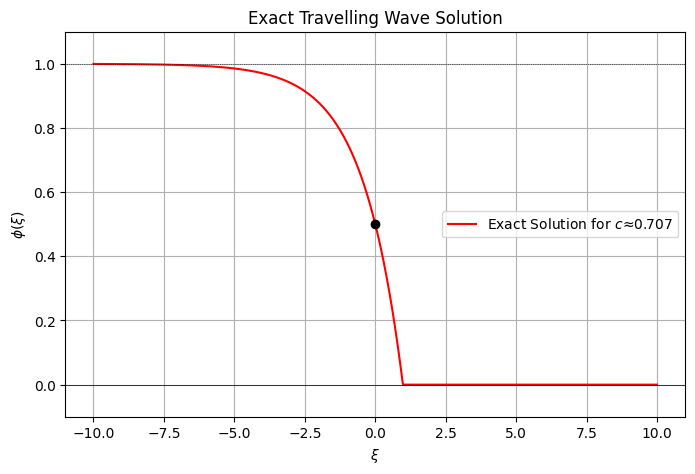

In [111]:
def plot_exact_solution():
    '''
    Calculates and plots the exact analytical solution for c = 1/sqrt(2).
    '''
    xi_1 = np.sqrt(2) * np.log(2)
    xi = np.linspace(-10, 10, 1000)
    phi = np.where(xi < xi_1, 1 - np.exp((xi - xi_1) / np.sqrt(2)), 0)

    plt.figure(figsize=(8, 5))
    plt.plot(xi, phi, label=f'Exact Solution for $c ≈ {1/np.sqrt(2):.3f}$', color='red')
    plt.title('Exact Travelling Wave Solution')
    plt.xlabel(f'$\\xi$')
    plt.ylabel(f'$\\phi(\\xi)$')
    plt.grid(True)
    plt.plot(0, 0.5, 'ko')
    plt.legend()
    plt.ylim(-0.1, 1.1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axhline(1, color='black', linewidth=0.5, linestyle=':')
    plt.show()

plot_exact_solution()